### Introduction
In this project we will classify news based on its content. The AG news dataset will be used for it. First, Naive Bayes model will be built based on a mutinomial event model. Next, recurrent neural network with long short-term memory units trained from scratch will be used. Finally, the same neural network will be used but this time with transfer learning - we use pretrained word embeddings from GloVe library.
### Import libraries 
We first import all necessary libraries.

In [1]:
import re
import sys
import chardet
import random
import html
import string
import nltk

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GlobalMaxPooling1D, Bidirectional

from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

# to display training progress & keep output clean
from IPython.display import clear_output

In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

### Load dataset
We load the dataset and we preliminary investigate it.

In [3]:
train_desc, train_label = tfds.as_numpy(tfds.load(
    'ag_news_subset',
    split='train',
    batch_size=-1,
    as_supervised=True,
))

Shuffling and writing examples to /root/tensorflow_datasets/ag_news_subset/1.0.0.incompleteMHGVLD/ag_news_subset-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/ag_news_subset/1.0.0.incompleteMHGVLD/ag_news_subset-test.tfrecord


Dataset ag_news_subset downloaded and prepared to /root/tensorflow_datasets/ag_news_subset/1.0.0. Subsequent calls will reuse this data.


Let's plot some of the news.

In [4]:
for row in train_desc[:10]:
  print(row)

b'AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.'
b'Reuters - Major League Baseball\\Monday announced a decision on the appeal filed by Chicago Cubs\\pitcher Kerry Wood regarding a suspension stemming from an\\incident earlier this season.'
b'President Bush #39;s  quot;revenue-neutral quot; tax reform needs losers to balance its winners, and people claiming the federal deduction for state and local taxes may be in administration planners #39; sights, news reports say.'
b'Britain will run out of leading scientists unless science education is improved, says Professor Colin Pillinger.'
b'London, England (Sports Network) - England midfielder Steven Gerrard injured his groin late in Thursday #39;s training session, but is hopeful he will be ready for Saturday #39;s World Cup qualifier against Austria.'
b'TOKYO - Sony Corp. is banking on the \\$3 billion deal to acquire Hollywood stu

Data is in byte string format, so it has to decoded to be properly handled. We first check encoding for 10 random rows.

In [5]:
for x in range(10):
  print(chardet.detect(train_desc[random.randint(0,len(train_desc))]))

{'encoding': 'ascii', 'confidence': 1.0, 'language': ''}
{'encoding': 'ascii', 'confidence': 1.0, 'language': ''}
{'encoding': 'ascii', 'confidence': 1.0, 'language': ''}
{'encoding': 'ascii', 'confidence': 1.0, 'language': ''}
{'encoding': 'ascii', 'confidence': 1.0, 'language': ''}
{'encoding': 'ascii', 'confidence': 1.0, 'language': ''}
{'encoding': 'ascii', 'confidence': 1.0, 'language': ''}
{'encoding': 'ascii', 'confidence': 1.0, 'language': ''}
{'encoding': 'ascii', 'confidence': 1.0, 'language': ''}
{'encoding': 'ascii', 'confidence': 1.0, 'language': ''}


### Data preprocessing
Encoding that has been used is ascii. Besides that some html leftovers are present in the text. We make a routine that will preprocess our text: it decodes the text, lowercase it, remove all redundant characters and finally we apply stemming.



In [6]:
nltk.download('stopwords')
nltk.download('punkt')

def process_text(text):
  # decode
  text = text.decode('ascii')
  # unescape html
  text = html.unescape(text)
  # lower
  text = text.lower()
  # dict for wrongly read html characters
  dictConv = {f' #{i};':chr(i) for i in range(255)}
  dictConv.update({f' {i};':chr(i) for i in range(255)})
  dictConv.update({f'0{i};':chr(i) for i in range(255)})
  dictConv['quot;'] = '' 
  dictConv['amp;'] = '' 
  dictConv['nbsp;'] = '' 
  dictConv['gt;'] = '' 
  dictConv['lt;'] = ''   
  dictConv[' 8217;'] = ''
  for key in dictConv.keys():
    text = text.replace(key, dictConv[key])
  # remove html signs
  text = re.sub('<[^<]+?>', '', text)
  # remove hyperlinks
  text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', 'url', text)
  # possible hastags
  text = re.sub(r'#', '', text)
  # unicode leftovers
  text = re.sub(r"\\x[0-9]+", ' ', str(text))
  # clean some other mess
  text = text.replace('\\', ' ')
  text = text.replace("'s", ' ')
  text = text.replace("\'", "'")
  #"""
  stemmer = PorterStemmer()
  stop_words = set(stopwords.words('english'))
  text_tokens = word_tokenize(text) 
  text_clean = []
  for word in text_tokens:
      if (word not in stop_words and  # remove stopwords
              word not in string.punctuation):  # remove punctuation
          # tweets_clean.append(word)
          stem_word = stemmer.stem(word)  # stemming word
          if stem_word.isalpha():
            text_clean.append(stem_word)
  
  return text_clean

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [7]:
train_x = [process_text(rev) for rev in train_desc]
train_y = train_label

Let's now check the data.

In [8]:
for row in train_x[:10]:
  print(row)

['amd', 'new', 'opteron', 'chip', 'design', 'mainli', 'corpor', 'comput', 'applic', 'includ', 'databas', 'web', 'servic', 'financi', 'transact']
['reuter', 'major', 'leagu', 'basebal', 'monday', 'announc', 'decis', 'appeal', 'file', 'chicago', 'cub', 'pitcher', 'kerri', 'wood', 'regard', 'suspens', 'stem', 'incid', 'earlier', 'season']
['presid', 'bush', 'tax', 'reform', 'need', 'loser', 'balanc', 'winner', 'peopl', 'claim', 'feder', 'deduct', 'state', 'local', 'tax', 'may', 'administr', 'planner', 'sight', 'news', 'report', 'say']
['britain', 'run', 'lead', 'scientist', 'unless', 'scienc', 'educ', 'improv', 'say', 'professor', 'colin', 'pilling']
['london', 'england', 'sport', 'network', 'england', 'midfield', 'steven', 'gerrard', 'injur', 'groin', 'late', 'thursday', 'train', 'session', 'hope', 'readi', 'saturday', 'world', 'cup', 'qualifi', 'austria']
['tokyo', 'soni', 'bank', 'billion', 'deal', 'acquir', 'hollywood', 'studio', 'inc']
['giant', 'panda', 'may', 'well', 'prefer', 'bam

### Data exploration
Data has been cleaned. Next, we build a pandas dataframe to gain more insight into data.

In [9]:
ds_stat = pd.DataFrame({'description': train_x, 'char_count': [len( " ".join(review)) for review in train_x],
                        'word_count': [len(review) for review in train_x], 'label':train_label})
ds_stat.describe()

,char_count,word_count,label
count,120000.000000,120000.000000,120000.000000
mean,118.920675,18.550267,1.500000
std,37.046116,5.712552,1.118039
min,0.000000,0.000000,0.000000
25%,96.000000,15.000000,0.750000
50%,117.000000,18.000000,1.500000
75%,138.000000,21.000000,2.250000
max,581.000000,93.000000,3.000000


On average preprocessed news has 19 words and the maximal news length is 93.

In [10]:
ds_stat

,description,char_count,word_count,label
0,"[amd, new, opteron, chip, design, mainli, corp...",98,15,3
1,"[reuter, major, leagu, basebal, monday, announ...",131,20,1
2,"[presid, bush, tax, reform, need, loser, balan...",132,22,2
3,"[britain, run, lead, scientist, unless, scienc...",80,12,3
4,"[london, england, sport, network, england, mid...",146,21,1
...,...,...,...,...
119995,"[ivan, ljubic, edg, seed, joachim, johansson, ...",133,21,1
119996,"[manama, billion, million, combin, power, wate...",99,14,2
119997,"[lo, hawk, begat, dove, least, one, imagin, pr...",141,24,0
119998,"[west, palm, beach, fl, sport, network, tom, l...",106,19,1


Let's check histogram of words count.

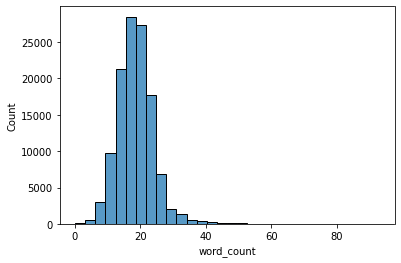

In [11]:
sns.histplot(data=ds_stat, x='word_count', bins=30)

And of the characters.

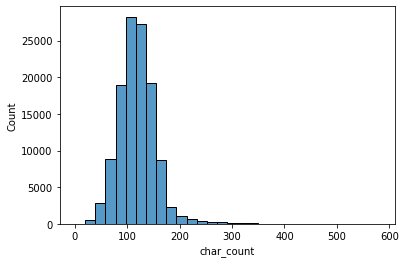

In [12]:
sns.histplot(data=ds_stat, x='char_count', bins=30)

Let's see if there is some substantial difference in char counts distrobution between classes.

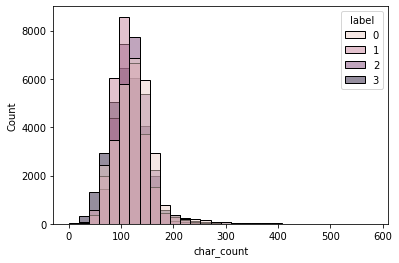

In [13]:
sns.histplot(data=ds_stat, x='char_count', hue='label', bins=30)

And whether the dataset is balanced.

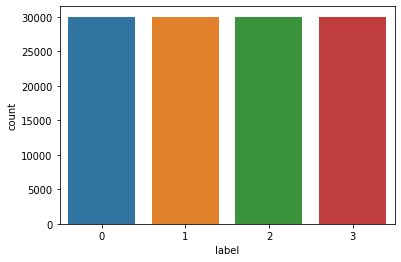

In [14]:
sns.countplot(x='label', data=ds_stat)

We also make a separate dictionary of frequencies for each of the classes.

In [15]:
def make_freqs(df):
  dicts = [{},{},{},{}]
  for index, row in df[['description', 'label']].iterrows():
    for word in row['description']:
      if word in dicts[row['label']]:
        dicts[row['label']][word] += 1
      else:
        dicts[row['label']][word] = 1
  return dicts
dicts = make_freqs(ds_stat)

And we check the most occuring words per class.

In [16]:
top = [np.array(sorted(dic.items(), key=lambda item: item[1], reverse=True)[:10]) for dic in dicts]

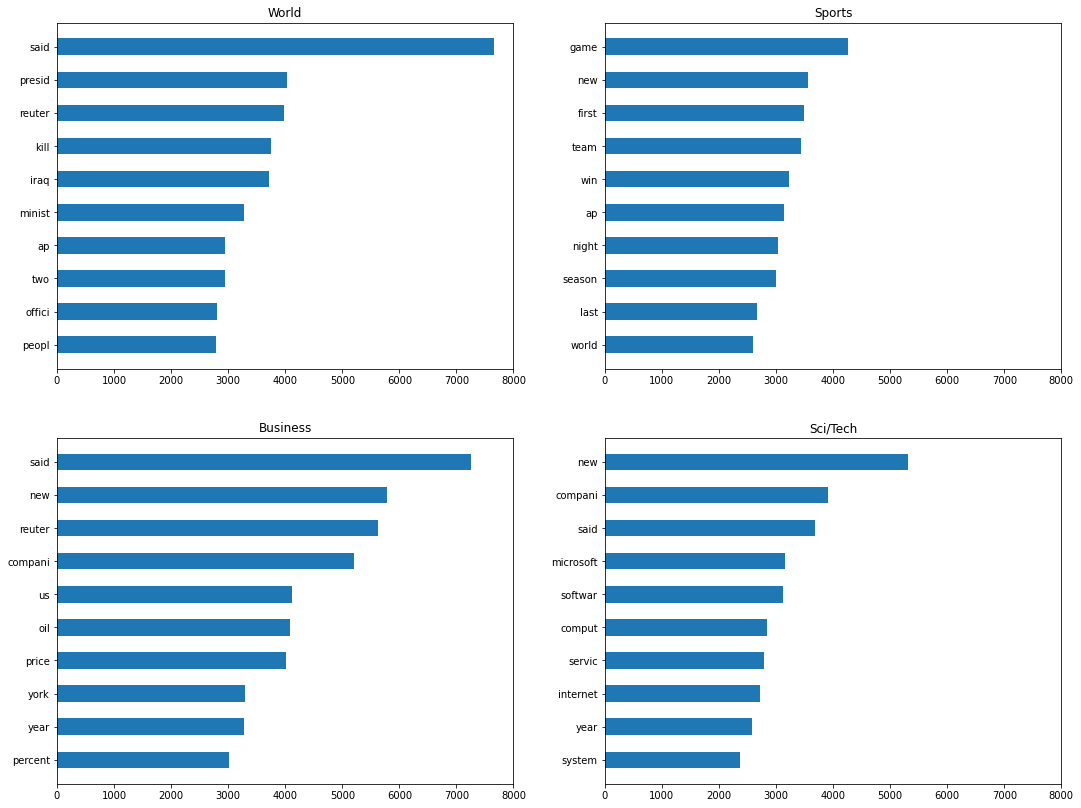

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(18, 14))  # Create the figure
titles = ['World', 'Sports', 'Business', 'Sci/Tech']
for i, ax in enumerate(axs.flatten()):
  rects = ax.barh(range(10), top[i][:,1][::-1].astype(int),
                    align='center',
                    height=0.5,
                    tick_label=top[i][:,0][::-1])
  ax.set_title(titles[i])
  ax.set_xlim((0, 8000))

There seem to be some overlap between Bussiness and Sci/Tech class for such a words as 'said', 'compani', 'new' or 'year'. This may influence performance of our model, especially for the Naive Bayes.  
Finally, let's check the total size of our vocabulary.

In [18]:
    vocab = set([key for freqs in dicts for key in freqs.keys() ])
    V = len(vocab)
    print("Number of unique words in vocabulary: {}".format(V))

Number of unique words in vocabulary: 39238


### Naive Bayes - training
First, we try Naive Bayes classifier. It is a simple and yet often really effective model. We may treat it here as a baseline to other, more advanced approaches.

In [19]:
def bayes_train(dicts, train_x, train_y):
    '''
    Input:
        dics: list of freqs dictionaries describing how often the word appears
              each dicts corresponds to a separate clas
        train_x: a list of news
        train_y: a list of labels correponding to the news
    Output:
        logprob: the log probabilitis of each word per class
        logprobclass: the log prior probability of each class
    '''
    class_n = len(np.unique(ds_stat['label'].values))

    # calculate V, the number of unique words in the vocabulary
    vocab = set([key for freqs in dicts for key in freqs.keys() ])
    V = len(vocab)

    # calculate the number of words per class
    N = [0]*class_n
    for cl, freqs in enumerate(dicts):
      for key in freqs.keys():
        N[cl] += freqs[key]

    # calculate D, the number of documents
    D = len(train_x)
    logprobclass = [0]*class_n
    for cl in range(class_n):
      logprobclass[cl] = np.log(np.sum(train_y==cl)/D)

    logprob = [{} for _ in range(class_n)]
    for word in vocab:
        # get probability of word in the class
        for cl in range(class_n):
          freq = dicts[cl].get(word, 0)
          p_w = (freq + 1.) / (N[cl] + V)
          # calculate the log likelihood of the word
          logprob[cl][word] = np.log(p_w)

    return logprob, logprobclass

In [20]:
logprob, logprobclass = bayes_train(dicts, train_x, train_y)

### Naive Bayes - testing
We create function to predict class for the unknown news and we run it on our test data.

In [21]:
def bayes_pred(text, logprob, logprobclass):
    '''
    Input:
        text: a string
        logprior: a number
        loglikelihood: a dictionary of words mapping to numbers
    Output:
        argmax(p): label of class with the maximum probability

    '''
    class_n = len(logprobclass)
    word_l = process_text(text)

    p = [0]*class_n
    for cl in range(class_n):
      p[cl] += logprobclass[cl]

      for word in word_l:
          if word in logprob[cl]:
              # add the log likelihood of that word to the probability
              p[cl] += logprob[cl][word]
    return np.argmax(p)

In [22]:
test_x, test_y = tfds.as_numpy(tfds.load(
    'ag_news_subset',
    split='test',
    batch_size=-1,
    as_supervised=True,
))

For model testing we use scikit learn functions.

In [23]:
def get_metric(test_y, y_hats):
    accuracy = accuracy_score(test_y, y_hats)
    recall = recall_score(test_y, y_hats, average='macro')
    precision = precision_score(test_y, y_hats, average='macro')
    f1s = f1_score(test_y, y_hats, average='macro')
    confusion = confusion_matrix(test_y, y_hats)
    return accuracy, recall, precision, f1s, confusion

In [24]:
y_hats = []
# iterate over examples
for text in test_x:
  y_hats.append(bayes_pred(text, logprob, logprobclass))
acc, rec, prec, f1s, conf = get_metric(test_y, y_hats)

In [25]:
print("Accuracy: {}, Recall: {}, Precision: {}, F1-Score: {}.".format(acc, rec, prec, f1s))

Accuracy: 0.8885526315789474, Recall: 0.8885526315789474, Precision: 0.88833903284449, F1-Score: 0.888349725302289.


Given that according to the rank on [paper with code](https://paperswithcode.com/sota/text-classification-on-ag-news) the accuracy of the best model so far is 95.55% our model yields really good results.  
Let's further investigate the source of error. For that we will use confusion matrix.

<Figure size 432x288 with 0 Axes>

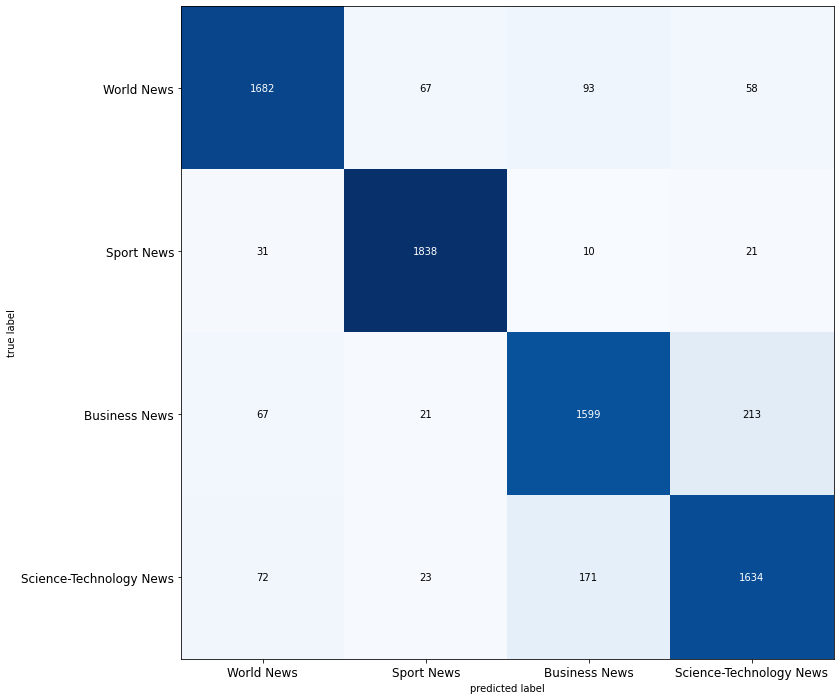

Accuracy per class is
World News: 0.89
Sport News: 0.97
Business News: 0.84
Science-Technology News: 0.86


In [26]:
def plot_cm(cm):
  labels = ['World News', 'Sport News', 'Business News', 'Science-Technology News']
  plt.figure()
  plot_confusion_matrix(cm, figsize=(16,12), hide_ticks=True, cmap=plt.cm.Blues)
  plt.xticks(range(4), labels, fontsize=12)
  plt.yticks(range(4), labels, fontsize=12)
  plt.show()
  class_acc = []
  print("Accuracy per class is")
  for i, row in enumerate(conf):
    print("{}: {:.2f}".format(labels[i], row[i]/np.sum(row)))
    
plot_cm(conf)

Clearly the overlap in important words between classes Bussiness and Sci/Tech influences their accuracy. And for them the error is the highest. The easiest to classify are Sport news.

### Recurrent neural networks - LSTMs
Now let's try some more advanced methods. We will use artificial recurrent networks which are suitable solution for sequence problems. We will use LSTMs, since our sequence length can be almost 100 and the problem of vanishing gradient for that long sequence may occur. We will use tensorflow library since it has many built-in functions that will speed-up the model creation.
### Import data
We again start with importing of the dataset.

In [27]:
train_desc, train_label = tfds.as_numpy(tfds.load(
    'ag_news_subset',
    split='train',
    batch_size=-1,
    as_supervised=True,
))

test_desc, test_label = tfds.as_numpy(tfds.load(
    'ag_news_subset',
    split='test',
    batch_size=-1,
    as_supervised=True,
))

### Data preprocessing
And we re-use the previous function to preprocess the raw text.

In [28]:
train_desc_n = [process_text(rev) for rev in train_desc]
test_desc_n = [process_text(rev) for rev in test_desc]

But this time we also join tokens back to string to apply TextVectorization on them.

In [29]:
train_x = [" ".join(row) for row in train_desc_n]
train_y = tf.one_hot(train_label, depth=4)

test_x = [" ".join(row) for row in test_desc_n]
test_y = test_label

In [30]:
VOCAB_SIZE = 10000
SEQUENCE_LENGTH = 100

vectorize_layer = TextVectorization(
    standardize=None,
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=SEQUENCE_LENGTH)

vectorize_layer.adapt(train_x)

In [31]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

train_x_tens, train_y_tens = vectorize_text(train_x, train_y)

We wrap out data back into tensorflow dataset.

In [32]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

train_dataset = tf.data.Dataset.from_tensor_slices((train_x_tens, train_y_tens))
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

### RNN with LSTMs - training
We build our model using two Bidirectional LSTM layers, making so-called deep recurrent neural network. It is connected to MaxPooling layer to generalize data and to prevent overfitting. Next, we connect it to searies of Dense hidden layers with drop-out in between. In front of it we use embedding layer which will transform our vectorized tokens into vector embeddings.

In [33]:
EMBED_SIZE = 100
model = Sequential()
model.add(Embedding(vocab_size, EMBED_SIZE, input_length=SEQUENCE_LENGTH))
model.add(Bidirectional(LSTM(128, return_sequences=True))) 
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(GlobalMaxPooling1D())
model.add(Dense(1024))
model.add(Dropout(0.25))
model.add(Dense(512))
model.add(Dropout(0.25))
model.add(Dense(256))
model.add(Dropout(0.25))
model.add(Dense(128))
model.add(Dropout(0.25))
model.add(Dense(64))
model.add(Dropout(0.25))
model.add(Dense(4, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100, 256)          234496    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 100, 128)          164352    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              132096    
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)              

We define EarlyStopping method based on validation accuracy and ModelCheckpoint to save out model.

In [34]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
callbacks = [
    EarlyStopping(   
        monitor='val_accuracy',
        min_delta=1e-4,
        patience=4,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='weights.h5',
        monitor='val_accuracy', 
        mode='max', 
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )
]

In [35]:
train_x_tens, train_y_tens = vectorize_text(train_x, train_y)
test_x_tens, test_y_tens = vectorize_text(test_x, test_y)

We compile it with ADAM optimizer with default hyperparameters. We use categorical cross entropy since our labels are one-hot encoded and we train the model for 20 epochs.

In [36]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=['accuracy']) 

model.fit(train_x_tens, 
          train_y_tens, 
          batch_size=256, 
          validation_data=(test_x_tens, test_y_tens), 
          epochs=20, 
          callbacks=callbacks)

Epoch 1/20
469/469 [==============================] - 34s 62ms/step - loss: 0.5793 - accuracy: 0.7710 - val_loss: 0.3079 - val_accuracy: 0.8946

Epoch 00001: val_accuracy improved from -inf to 0.89461, saving model to weights.h5
Epoch 2/20
469/469 [==============================] - 28s 60ms/step - loss: 0.2570 - accuracy: 0.9164 - val_loss: 0.2779 - val_accuracy: 0.9071

Epoch 00002: val_accuracy improved from 0.89461 to 0.90711, saving model to weights.h5
Epoch 3/20
469/469 [==============================] - 28s 59ms/step - loss: 0.2011 - accuracy: 0.9323 - val_loss: 0.3211 - val_accuracy: 0.9025

Epoch 00003: val_accuracy did not improve from 0.90711
Epoch 4/20
469/469 [==============================] - 28s 59ms/step - loss: 0.1596 - accuracy: 0.9449 - val_loss: 0.3199 - val_accuracy: 0.8974

Epoch 00004: val_accuracy did not improve from 0.90711
Epoch 5/20
469/469 [==============================] - 28s 59ms/step - loss: 0.1283 - accuracy: 0.9549 - val_loss: 0.3325 - val_accuracy: 0.

Mddel really ruickly finds the optimum and accuracy has improved by almost 2% when compared to Naive Bayes approach.
### RNN with LSTMs - testing


In [37]:
y_hats = np.argmax(model.predict(test_x_tens), axis=1)
acc, rec, prec, f1s, conf = get_metric(test_y, y_hats)
print("Accuracy: {}, Recall: {}, Precision: {}, F1-Score: {}.".format(acc, rec, prec, f1s))

Accuracy: 0.8955263157894737, Recall: 0.8955263157894736, Precision: 0.8962510496922456, F1-Score: 0.8958084001171104.


<Figure size 432x288 with 0 Axes>

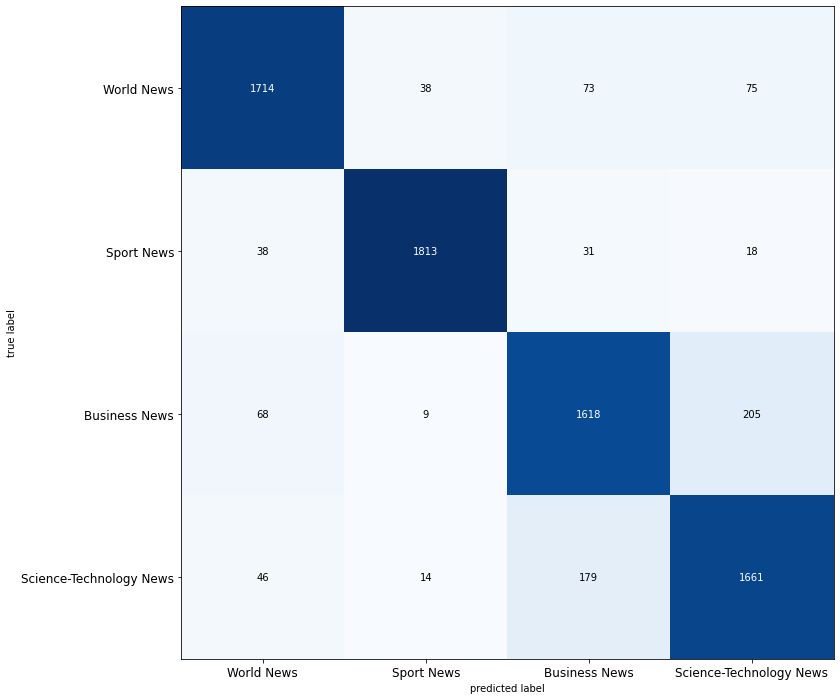

Accuracy per class is
World News: 0.90
Sport News: 0.95
Business News: 0.85
Science-Technology News: 0.87


In [38]:
plot_cm(conf)

The same trend of mixing Business with Science-Technology can be observed but this time the accuracy between classes is slightly better balanced.
### RNN with LSTMs and transfer learning
As a final step we try the same model architecture but this time we use pretrained vector embeddings. For that GloVe data will be used.
### Data preprocessing
This time we will used different function for data preprocessing that mimicks routines used by GloVe algorithm. We do it because we want to apply the same word->vector map as the creators of GloVe.

In [39]:
FLAGS = re.MULTILINE | re.DOTALL

def hashtag(text):
  text = text.group()
  hashtag_body = text[1:]
  if hashtag_body.isupper():
      result = "<hashtag> {} <allcaps>".format(hashtag_body)
  else:
      result = " ".join(["<hashtag>"] + re.split(r"(?=[A-Z])", hashtag_body, flags=FLAGS))
  return result

def allcaps(text):
  text = text.group()
  return text.lower() + " <allcaps>"


def tokenize(text, decode=True):
  # Different regex parts for smiley faces
  eyes = r"[8:=;]"
  nose = r"['`\-]?"

  # decode
  if decode:
    text = text.decode('ascii')
  # unescape html
  text = html.unescape(text)
  # dict for wrongly read html signs
  dictConv = {f' #{i};':chr(i) for i in range(255)}
  dictConv.update({f' {i};':chr(i) for i in range(255)})
  dictConv.update({f'0{i};':chr(i) for i in range(255)})
  dictConv['quot;'] = '' 
  dictConv['amp;'] = '' 
  dictConv['nbsp;'] = '' 
  dictConv['gt;'] = '' 
  dictConv['lt;'] = ''   
  dictConv[' 8217;'] = ''
  for key in dictConv.keys():
    text = text.replace(key, dictConv[key])

  # function so code less repetitive
  def re_sub(pattern, repl):
      return re.sub(pattern, repl, text, flags=FLAGS)
  text = re_sub(r"https?:\/\/\S+\b|www\.(\w+\.)+\S*", "<url>")
  text = re_sub(r"/"," / ")
  text = re_sub(r"@\w+", "<user>")
  text = re_sub(r"{}{}[)dD]+|[)dD]+{}{}".format(eyes, nose, nose, eyes), "<smile>")
  text = re_sub(r"{}{}p+".format(eyes, nose), "<lolface>")
  text = re_sub(r"{}{}\(+|\)+{}{}".format(eyes, nose, nose, eyes), "<sadface>")
  text = re_sub(r"{}{}[\/|l*]".format(eyes, nose), "<neutralface>")
  text = re_sub(r"<3","<heart>")
  text = re_sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", "<number>")
  text = re_sub(r"#\S+", hashtag)
  text = re_sub(r"([!?.]){2,}", r"\1 <repeat>")
  text = re_sub(r"\b(\S*?)(.)\2{2,}\b", r"\1\2 <elong>")

  # unicode leftovers
  text = re.sub(r"\\x[0-9]+", ' ', str(text))
  # clean some other mess
  text = text.replace('\\', ' ')
  text = text.replace("'s", ' ')
  text = text.replace("\'", "'")

  return text.lower()

We load and preprocess the data.

In [40]:
train_desc, train_label = tfds.as_numpy(tfds.load(
    'ag_news_subset',
    split='train',
    batch_size=-1,
    as_supervised=True,
))

test_desc, test_label = tfds.as_numpy(tfds.load(
    'ag_news_subset',
    split='test',
    batch_size=-1,
    as_supervised=True,
))

In [41]:
train_x = [tokenize(rev) for rev in train_desc]
train_y = tf.one_hot(train_label, depth=4)
test_x = [tokenize(rev) for rev in test_desc]
test_y =  tf.one_hot(test_label, depth=4)

Let's see how the preprocessed data looks like.

In [42]:
train_x[:10]

['amd  new dual-core opteron chip is designed mainly for corporate computing applications, including databases, web services, and financial transactions.',
 'reuters - major league baseball monday announced a decision on the appeal filed by chicago cubs pitcher kerry wood regarding a suspension stemming from an incident earlier this season.',
 "president bush   revenue-neutral  tax reform needs losers to balance its winners, and people claiming the federal deduction for state and local taxes may be in administration planners' sights, news reports say.",
 'britain will run out of leading scientists unless science education is improved, says professor colin pillinger.',
 'london, england (sports network) - england midfielder steven gerrard injured his groin late in thursday  training session, but is hopeful he will be ready for saturday  world cup qualifier against austria.',
 'tokyo - sony corp. is banking on the  $<number> billion deal to acquire hollywood studio metro-goldwyn-mayer in

Again text vectorization will be used.

In [43]:
vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=100)
vectorizer.adapt(train_x)

def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorizer(text), label

train_x_tens, train_y_tens = vectorize_text(train_x, train_y)

In [44]:
train_x_tens, train_y_tens = vectorize_text(train_x, train_y)
test_x_tens, test_y_tens = vectorize_text(test_x, test_y)

Let's see the first five tokens.

In [45]:
vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'the', 'a', 'to']

And how a tokenized sentence looks like.

In [46]:
output = vectorizer([["President went to space."]])
output.numpy()[0, :6]

array([ 66, 748,   4, 222,   0,   0])

We create dictionary that maps words from vocabulary to a unique index.

In [47]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

### Transfer learning
As mentioned we will use pretrained word embeddings. For that we download GloVe data from stanford website.

In [48]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2021-04-28 17:46:36--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-04-28 17:46:36--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-04-28 17:46:36--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove

We load the word embeddings.

In [49]:
embeddings_index = {}
with open('glove.6B.100d.txt') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


And we create embedding matrix that maps words from our vocabulary to corresponding pretrained vector.

In [50]:
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 18673 words (1327 misses)


### RNN with LSTMs and transfer learning - training
Again we define the same model architecture but this time with a fixed embedding layer.

In [51]:
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

In [52]:
embed_size = 100
model = Sequential()
model.add(embedding_layer)
model.add(Bidirectional(LSTM(128, return_sequences=True))) 
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.25))
model.add(Dense(512))
model.add(Dropout(0.25))
model.add(Dense(256))
model.add(Dropout(0.25))
model.add(Dense(128))
model.add(Dropout(0.25))
model.add(Dense(64))
model.add(Dropout(0.25))
model.add(Dense(4, activation='softmax'))A
A
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         2000200   
_________________________________________________________________
bidirectional_4 (Bidirection (None, None, 256)         234496    
_________________________________________________________________
bidirectional_5 (Bidirection (None, None, 128)         164352    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 1024)              132096    
_________________________________________________________________
dropout_10 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 512)              

In [53]:
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        min_delta=1e-4,
        patience=4,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='weights.h5',
        monitor='val_accuracy', 
        mode='max', 
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )
]

In [54]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=['accuracy']) 

model.fit(train_x_tens, 
          train_y_tens, 
          batch_size=256, 
          validation_data=(test_x_tens, test_y_tens), 
          epochs=20, 
          callbacks=callbacks)

Epoch 1/20
469/469 [==============================] - 29s 50ms/step - loss: 0.4743 - accuracy: 0.8305 - val_loss: 0.2947 - val_accuracy: 0.8925

Epoch 00001: val_accuracy improved from -inf to 0.89250, saving model to weights.h5
Epoch 2/20
469/469 [==============================] - 22s 47ms/step - loss: 0.2882 - accuracy: 0.9008 - val_loss: 0.2757 - val_accuracy: 0.9009

Epoch 00002: val_accuracy improved from 0.89250 to 0.90092, saving model to weights.h5
Epoch 3/20
469/469 [==============================] - 22s 47ms/step - loss: 0.2570 - accuracy: 0.9105 - val_loss: 0.2666 - val_accuracy: 0.9086

Epoch 00003: val_accuracy improved from 0.90092 to 0.90855, saving model to weights.h5
Epoch 4/20
469/469 [==============================] - 22s 47ms/step - loss: 0.2337 - accuracy: 0.9190 - val_loss: 0.2597 - val_accuracy: 0.9083

Epoch 00004: val_accuracy did not improve from 0.90855
Epoch 5/20
469/469 [==============================] - 22s 47ms/step - loss: 0.2120 - accuracy: 0.9272 - val

91.5% is a satisfying result given that the achieved score is 95.5% and that we are here using a relatively simple neural network. Next, we further check accuracy of our model.

In [55]:
y_hats = np.argmax(model.predict(test_x_tens), axis=1)
acc, rec, prec, f1s, conf = get_metric(test_label, y_hats)
print("Accuracy: {}, Recall: {}, Precision: {}, F1-Score: {}.".format(acc, rec, prec, f1s))

Accuracy: 0.9123684210526316, Recall: 0.9123684210526316, Precision: 0.9132504987599803, F1-Score: 0.9124081881010238.


<Figure size 432x288 with 0 Axes>

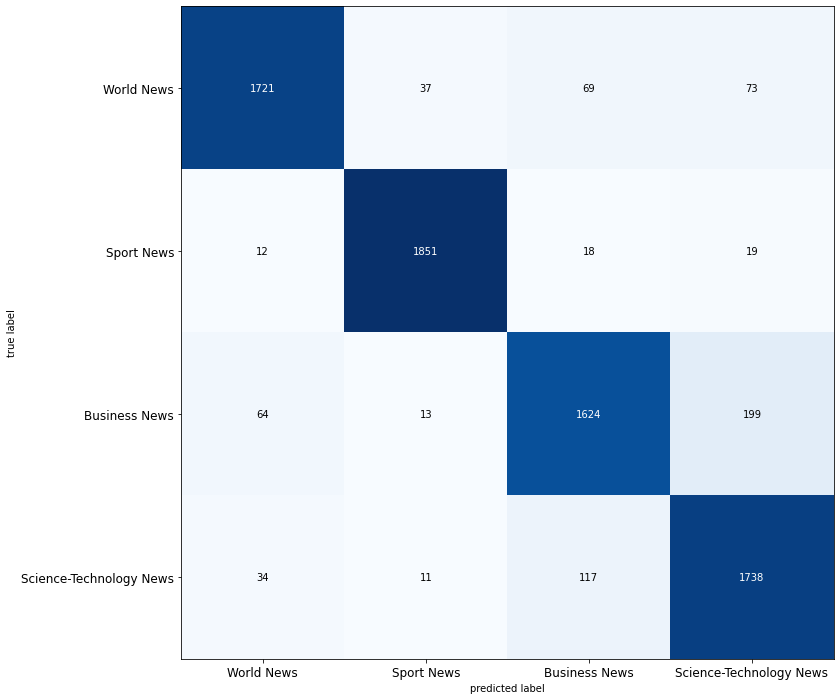

Accuracy per class is
World News: 0.91
Sport News: 0.97
Business News: 0.85
Science-Technology News: 0.91


In [56]:
plot_cm(conf)

Accuracy of Science-Technology has improved but there are still problems with Bussiness News. Let's check some of the mistakes.

In [57]:
test_desc[np.where(np.logical_and((test_label == 2), (y_hats == 3)))[0][:10]]

array([b'Next week, the FCC will likely change the rules on unbundled networks largely in ways favorable to the Regional bells.',
       b'The company has no further expansion plans after buying a Chinese website. Also: Virgin joins quest for a better iPod   hellip;. PeopleSoft makes promise that Oracle will live up to   hellip;. and more.',
       b' quot;Apple has invested heavily in technology to edit pictures. Not having a portable device to show them seemed an obvious oversight that would be corrected once the price of the displays ',
       b'German industrial giant Siemens has signed a 2.69bn contract to deliver technology services around the world to the BBC, a deal that will see it acquire the broadcasters technology subsidiary.',
       b"SEATTLE -- Not too long ago, Google Inc. seemed little more than a pesky insect to Microsoft Corp.'s 800-pound gorilla.",
       b'If you #39;ve ever been in an airplane that has to abort a landing, you know that it is a completely hair-rais

Clearly many of the business news are about tech companies and they can be easily misclassified as sci-tech news even by human.

### Model for classification
As a final step, we build a function that classifies a text based on our model.

In [58]:
def classify(text, decode=False):
  labels = ['World News', 'Sports News', 'Business News', 'Science-Technology News']
  text_proc = tokenize(text, decode)
  text_vec = vectorizer([text_proc])
  #text_vec = tf.expand_dims(text_vec, axis=0)
  pred = np.argmax(model.predict(text_vec))
  print('{} - {}'.format(text, labels[pred]))

In [59]:
classify("Rocket went to space.")

Rocket went to space. - Science-Technology News


In [60]:
classify("President met with me.")

President met with me. - World News


In [61]:
classify("Unemployment decreases.")

Unemployment decreases. - Business News


In [62]:
classify("New basketball season begins.")

New basketball season begins. - Sports News


As we can see, the classifier is quite effective.

### Conclusions
We have used the Naive Bayes method and deep recurrent neural networks with LSTMs with and without transfer learning to classify the news articles. The best accuracy was obtained with RNNs combined with transfer learning (91.5%) but even with simple Naive Bayes classifier 88% were achieved. The obtained results were satisfactory given that the best models based on transformers achieve accuracy of 95%.